<span style="font-size:3em;font-weight:500">Стабилизация перевёрнутого маятника с неподвижной осью подвеса</span>

<span style="font-size:2em;font-weight:500">Расчётно-графическая работа для лабораторного практикума. Задания. Часть 1. Линейные и нелинейные стратегии управления</span>

**Автор: В. А. Костин**  

**2025 год**
$\newcommand{\ctg}{\mathop{\mathrm{ctg}}\nolimits}$
$\newcommand{\tg}{\mathop{\mathrm{tg}}\nolimits}$
$\newcommand{\arctg}{\mathop{\mathrm{arctg}}\nolimits}$
$\newcommand{\degree}{^{\circ}}$
$\renewcommand{\Re}{\mathop{\mathrm{Re}}\nolimits}$
$\newcommand{\D}{\mathrm{d}}$

# Задание 1. Инициализация параметров маятника

*Запишите в соответствующие переменные номер группы, фамилию, имя и отчество выполняющего работу.* *После этого запустите на выполнение изменённую ячейку и три следующие ячейки с кодом*. Запустить на выполнение текущую (в которой находится курсов) ячейку можно с помощью сочетания клавиш `Shift` и `Enter` или с помощью кнопки `Run` на панели инструментов. В результате выполнения этих ячеек будут исполнены подготовительные инструкции, подключены необходимые научные пакеты и вспомогательный модуль `control_theory`. Кроме этого будут созданы индивидуальные виртуальные маятники `p1` и `p2` со случайно сгенерированными параметрами (на основе предоставленных данных в качестве зерна случайной генерации). Для маятника `p1` управляющим воздействием является внешний момент сил, а для маятника `p2`&nbsp;— горизонтальная сила; оба маятника имеют одну и ту же частоту и коэффициент затухания. При перезапуске ядра Python необходимо каждый раз запускать эти четыре ячейки заново. Перед выходом или обновлением страницы используйте кнопку сохранения `Save and create checkpoint` (с пиктограммой, изображающей мягкий магнитный диск) или соответствующий пункт в меню `File` или сочетание клавиш `Control` и `S`.

## Решение

In [1]:
student_group = 'Группа'
student_first_name = 'Имя'
student_father_name = 'Отчество'
student_last_name = 'Фамилия'

## Подключение и настройка необходимых модулей, инициализация маятника со случайно сгенерированными параметрами

In [2]:
# Подключение объектов из библиотек numpy и matplotlib для более удобной
# дальнейшей интерактивной работы
from pylab import *

# Подключение объектов из вспомогательного модуля control_theory
from control_theory import *

# Импорт функции `HTML` для отображения произвольного кода HTML в выводе
# ячейки
from IPython.display import HTML, Video, Image

In [3]:
# Настройка вывода рисунков Matplotlib для интерактивной работы. Параметр
# inline указывает на то, что рисунки matplotlib должны быть встроены как
# растровые изображения, для интерактивных рисунков на javascript можно
# использовать параметр notebook вместо inline. Команда %matplotlib --list
# выводит список возможных типов вывода (бэкендов).
%matplotlib inline

# Настройка размеров и разрешения рисунков (960x720 по умолчанию, можно
# изменить для комфортной работы на мониторах с малым разрешением)
rcParams['figure.figsize'] = (9.6, 7.2) # Размер рисунков по умолчанию
rcParams['figure.dpi'] = 100 # Разрешение рисунков по умолчанию

rcParams['animation.embed_limit'] = 2.5 # Максимальный размер анимации в МБ
rcParams['animation.html'] = 'html5' # Представление анимаций matplotlib 

In [4]:
# Инициализация индивидуального маятника обучающегося
seed = (int(hashlib.md5((student_group
                         + student_first_name
                         + student_father_name
                         + student_last_name).encode('utf-8')).hexdigest(), 16)
        % 2**32)
np.random.seed(seed)

temp = np.random.rand(2)
p1 = PendulumTorque(0.3 + 1.5*temp[0], 0.01 + 0.1*temp[1]) 
p2 = PendulumHorizontalForce(0.3 + 1.5*temp[0], 0.01 + 0.1*temp[1])

# Вывод параметров маятника
print(p1, p2, sep='\n')

Pendulum controlled by applied torque: omega = 0.99, nu = 0.11
Pendulum controlled by applied horizontal force: omega = 0.99, nu = 0.11


<a name="sec:pr9"></a>
# Задание 9. Метод обратной задачи динамики

Общая теория линеаризации обратной связью достаточно сложна для начала курса теории управления и основана на методах дифференциальной геометрии, в частности на теореме Фробениуса, и, как мы увидем далее для маятника `p2`, такая линеаризация возможна не для всех систем. В предыдущем [задании 8](#sec:pr8) нам удалось провести линеаризацию обратной связью так легко, потому что управление выражалось явно через угол $\varphi$ и его временные производные. Фактически уравнение&nbsp;[$(4)$](description.ipynb#eq:phi) явно выражает управление $u$,
$$
  u = -\ddot \varphi - \nu\dot\varphi + \Omega^2 \sin\varphi.
$$
По сути такое выражение даёт решение **обратной задачи динамики (_англ_ inverse problem)**, то есть задачи о том, какими должны быть внешние силы (в нашем случае момент сил), обеспечивающие заданное движение системы. При этом можно задаваться как конкретным движением $\varphi(t)$, находя подходящее **программное управление** $u(t)$, так и некоторой целевой (желаемой) замкнутой системой $\ddot\varphi = g(\varphi, \dot\varphi, t)$, которой должен подчиняться маятник под управлением. В самом деле, если выбрать стратегию управления
$$
  u = -g(\varphi, \dot\varphi, t) - \nu\dot\varphi + \Omega^2 \sin\varphi,
$$
то замкнутая система как раз примет желаемый вид. А если положить $g(\varphi, \dot\varphi, t) = -k_0\varphi - (k_1 + \nu) \dot\varphi$, получим систему линеаризованную обратной связью из предыдущего задания.

В случае если целевое движение описывается системой меньшей размерности, чем два, то можно добавить дополнительные динамические звенья слежения, увеличив таким образом размерность системы до двух. Например, для системы $\dot\varphi = h(\varphi, t)$ записываем уравнение $\tau_{\mathrm{g}} \dot e + e = 0$ для ошибки $e = \dot\varphi - h(\varphi, t)$, где $\tau_{\mathrm{g}} > 0$&nbsp;— время выхода на целевое решение. Аналогично для целевого движения $\varphi = f(t)$ можно записать уравение второго порядка $(\alpha\tau_{\mathrm{g}}^2/4) \ddot e + \tau_{\mathrm{g}} \dot e + e = 0$ для ошибки $e = \varphi - f(t)$ с характерными временами $\tau_{\mathrm{g}} > 0$ и параметром $\alpha > 0$, который определяет наличие и частоту переколебаний, а также относительную величину перерегулирования при выходе на целевой режим.

*Используя метод обратной задачи динамики, синтезируйте управление (то есть запишите соответствующие формулы), которое реализует заданные установившиеся режимы*:
- 1\) *равномерное вращение маятника с заданной угловой скоростью $\Omega_{\mathrm{g}}$*;
- 2\) *отклонение маятника на постоянный угол $\varphi_{\mathrm{g}}$*;
- 3\) *гармонические колебания угла отклонения маятника от вертикали с амплитудой $\varphi_{\mathrm{g}}$ и частотой $\Omega_{\mathrm{g}}$*.

*Для всех трёх примеров реализуйте регуляторы с помощью компьютерной симуляции (используйте класс `StateFeedbackControl`), постройте графики зависимостей угла отклонения и управления от времени и фазовые потреты замкнутых систем (на фазовых портретах отметьте устойчивые и неустойчивые аттракторы: состояния равновесия и предельные циклы). В симуляциях положите $\tau_{\mathrm{g}} = 10$, $\alpha = 1$, $\Omega_{\mathrm{g}} = 1$, $\varphi_{\mathrm{g}} = \pi/2$. В качестве начальных условий выберите маятник, стартующий из нижнего положения с нулевой скоростью. Для первого примера проверьте, что произойдёт, если при построении регуляторов была допущена ошибка в определении значения $\Omega$ и оно оказалось занижено или завышено на 20 \%.*

## Решение

### 9.1. Целевой режим с равномерным вращением маятника

*Запишите вывод аналитических выражений для синтезированного управления.*

In [15]:
# Вставьте и запустите код для построения графиков временной реализации

In [16]:
# Вставьте и запустите код для построения анимации (необязательно)

In [17]:
# Вставьте и запустите код для построения фазового портрета

### 9.2. Целевой режим с отклонением маятника на постоянный угол

*Запишите вывод аналитических выражений для синтезированного управления.*

In [20]:
# Вставьте и запустите код для построения графиков временной реализации

In [21]:
# Вставьте и запустите код для построения анимации (необязательно)

In [22]:
# Вставьте и запустите код для построения фазового портрета

### 9.3. Целевой режим с гармоническими автоколебаниями маятника

*Запишите вывод аналитических выражений для синтезированного управления.*

In [25]:
# Вставьте и запустите код для построения графиков временной реализации

In [26]:
# Вставьте и запустите код для построения анимации (необязательно)

In [27]:
# Вставьте и запустите код для построения фазового портрета

### 9.4. Целевой режим с равномерным вращением маятника при ошибке в определении $\Omega$ 

In [29]:
# Вставьте и запустите код для построения графиков временной реализации

In [30]:
# Вставьте и запустите код для построения анимации (необязательно)

*Запишите аналитические выражения для отрицательных корней характеристических полиномов уравнений, линеаризованных около сёдел.*

In [32]:
# Вставьте и запустите код для построения фазового портрета

*Запишите вывод о том, что происходит, если допушена ошибка идентификации параметра $\Omega$.*

<a name="sec:pr10"></a>
# Задание 10. Периодические по углу стратегии управления

С помощью метода линеаризации обратной связью в [задании 8](#sec:pr8) были построены регуляторы, которые одновременно являются стабилизирующими (удерживают маятник в вертикальном положении при малых отклонениях от него) и подъёмными (приводят маятник из любого состояния в окрестность верхнего положения равновесия). Однако для данной конкретной системы недостатком такого регулятора может являться то, что этот регулятор оказывается чувствительным к числу оборотов, то есть различает углы, отличающиеся на $2\pi n$, $n \in \mathbb Z$. От этого недостатка можно избавиться, если синтезировать регулятор с замкнутой системой, инвариантной относительно замены $\varphi \mapsto \varphi + 2\pi$. Для этого опять можно использовать метод обратной динамики. В качестве замкнутой системы можно рассмотреть систему, аналогичную исходной незамкнутой, но с другим знаком коэффициента перед $\sin\varphi$: $\ddot\varphi + a\dot\varphi + b\sin\varphi = 0$, где $a$ и $b$&nbsp;— постоянные положительные коэффициенты. Для того чтобы иметь возможность сравнить с [заданием 8](#sec:pr8) можно выбрать значения коэффициентов так, чтобы линеаризации замкнутых систем совпадали с целевыми линейными системами в [задании 8](#sec:pr8), то есть $a = 1$, $b = 0.2$ и $a = 0.2$, $b = 1$. *Постройте такие регуляторы для маятника `p1`. Проведите компьютерные симуляции для начальных условий $\varphi(0) = 5\pi$, $\dot\varphi(0) = 0.001$. Постройте фазовые портреты.*

Как видно, недостатком полученных систем является наличие дополнительного неустойвого состояния равновесия, вблизи которого система может проводить значительное время. Поэтому другим вариантом является использование систем с разрывами, например, $\ddot\varphi + a\dot\varphi + b\mathop{\mathrm{sawtooth}}\varphi$, где $\mathop{\mathrm{sawtooth}} x = 2\arctg \tg(x/2) = \pi - \left[(\pi - x) \mathrel{\mathrm{mod}} 2\pi\right]$&nbsp;— функция-пила. *Постройте и такие регуляторы  для маятника `p1`. Проведите компьютерные симуляции для начальных условий $\varphi(0) = 5\pi$, $\dot\varphi(0) = 0.001$. Постройте фазовые портреты.*

## Решение

### 10.1 Целевая система $\ddot\varphi + \dot\varphi + 0.2\sin\varphi = 0$

*Запишите аналитическое выражение для синтезированного управления.*

In [39]:
# Вставьте и запустите код для построения графиков временной реализации

In [40]:
# Вставьте и запустите код для построения анимации (необязательно)

In [41]:
# Вставьте и запустите код для построения фазового портрета

### 10.2. Целевая система $\ddot\varphi + 0.2\dot\varphi + \sin\varphi = 0$

*Запишите аналитическое выражение для синтезированного управления.*

In [44]:
# Вставьте и запустите код для построения графиков временной реализации

In [45]:
# Вставьте и запустите код для построения анимации (необязательно)

In [46]:
# Вставьте и запустите код для построения фазового портрета

### 10.3. Целевая система $\ddot\varphi + \dot\varphi + 0.2\mathop{\mathrm{sawtooth}}\varphi = 0$

*Запишите аналитическое выражение для синтезированного управления.*

In [49]:
# Вставьте и запустите код для построения графиков временной реализации

In [50]:
# Вставьте и запустите код для построения анимации (необязательно)

In [51]:
# Вставьте и запустите код для построения фазового портрета

### 10.4. Целевая система $\ddot\varphi + 0.2\dot\varphi + \mathop{\mathrm{sawtooth}}\varphi = 0$

*Запишите аналитическое выражение для синтезированного управления.*

In [54]:
# Вставьте и запустите код для построения графиков временной реализации

In [55]:
# Вставьте и запустите код для построения анимации (необязательно)

In [56]:
# Вставьте и запустите код для построения фазового портрета

<a name="sec:pr11"></a>
# Задание 11. Показатели качества

Кроме собственно требования устойчивости (стабилизации верхнего положения равновесия), к системе управления могут предъявляться и иные требования, в совокупности именуемые **качеством системы управления (_англ._ performance of a control system)**. Это могут быть требования к самому управлению $u$, например ограничение на прикладываемую силу, то есть на максимальное по времени значение модуля, $u_{\max} = \max_{t > 0}\left|u(t)\right|$, для определённых начальных отклонений.
Может накладываться и ограничение на энергию, затраченную на приведение, то есть ограничение на $W = \int_0^{\inf} u^2(t) \,\D{t}$. Часто ставятся ограничения на характеристики переходного процесса, например на величину перерегулирования, то есть на максимальную по времени величину отклонения маятника в сторону, противоположную начальному отклонению. Могут задаваться как требования на относительную величину перегулирования $\sigma = -\min_{t > 0} \frac{\varphi(t)}{\varphi(0)}$ (обычно, выражаемую в процентах), так и на абсолютную $\sigma\left|\varphi(0)\right|$. Важным показателем качества является время установления (время регулирования), которое можно определять различными способами, например как то верхнюю грань времён, для которых отклонение больше некоторой доли $\beta$ начального отклонения. Здесь мы будем использовать определение
$$\tau_{\mathrm{r}} = \frac 1{\ln(1/\beta)}\sup_{d(t) > \beta d(0)} t$$
с $\beta = 5\ \%$ и $d(t) = \sqrt{\dot\varphi^2(t) + 2\Omega^2\sin^2(\varphi/2)}$&nbsp;— вариант расстояния на фазовом цилиндре между точками $(\varphi, \dot\varphi)$ и $(0, 0)$. Нормирующий множитель $\frac 1{\ln(1/\beta)}$ здесь введён, для того чтобы для экспоненциального установления $d(t) \propto \exp(-\gamma t)$ имело место $\tau_{\mathrm{r}} = 1/\gamma$. Для сильно зашумлённых сигналов удобно определять время установления интегрально, например как
$$\tau_{\mathrm{est}} = 2\frac{\int_0^{\infty} t d^2(t)\,\D t}{\int_0^{\infty} d^2(t)\,\D t}.$$
Для экспоненциального затухания $d(t) \propto \exp(-\gamma t)$ оба определения дают одну и ту же величину $\tau_{\mathrm{est}} = \tau_{\mathrm{r}} = 1/\gamma$.
В определение $\tau_{\mathrm{est}}$ входит другой часто используемый показатель&nbsp;— интегральная квадратичная ошибка $J = \int_0^{\infty} d^2(t)\,\D t$, также характеризующая скорость установления. В случае если бассейн притяжения целевого режима не совпадает со всем фазовым пространством, можно рассматривать характеристики этого бассейна, как например критический начальный угол $\varphi_{\mathrm{c}}$ для маятника `p2`, введённый в [задании 7](#sec:pr7), или аналогично вводимую критическую начальную угловую скорость.

*Расширив пример, приведённый ниже, рассчитайте показатели качества $u_{\max}$, $W$, $\sigma$, $\tau_{\mathrm{r}}$, $\tau_{\mathrm{est}}$ и $J_0$ как функцию коэффициента $b \in [0.1\Omega^2, 5\Omega^2]$ для целевых замкнутых систем из предыдущего [задания 9](#sec:pr9). Рассмотрите начальные условия $\varphi(0) = 0.1\pi$, $0.5\pi$, $0.9\pi$ для значений коэффциентов $a = 0.2$ и $a = 1$. Какие рекомендации можно дать относительно выбора коэффциентов $a$ и $b$ и вида стратегии управления (из двух рассмотренных).*

## Пример построения показателей качества $u_{\max}$ и $W$ для линейных стратегий управления

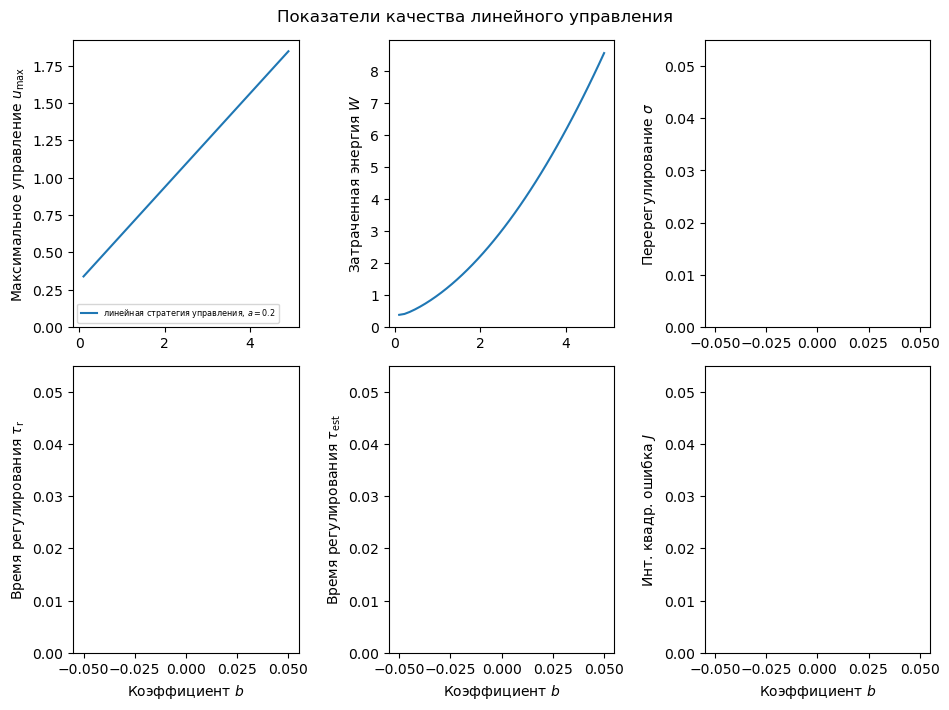

In [60]:
# Функция для нахождения расстояния на цилиндре
def cylinder_distance(s):
    return sqrt(s[:, 1]**2/2 + 2*p1.omega**2*sin(s[:, 0]/2)**2)

# Расчёт показателей качества для управления c и начальных условий x0
def performance_indicators(c, x0):
    t, s, u = integrate(p1, c, x0=x0, v0=empty(0), dt=0.01, T=300, N=1,
                        return_control=True,
                        stop_condition=lambda x, t: norm(x) < 1e-8)
    umax = amax(abs(u[:, 0]))
    W = trapz(u[:, 0]**2, t)
    sigma = nan # nan везде необходимо заменить на правильный код
    taur = nan
    J0 = nan
    tauest = nan / J0
    return (umax, W, sigma, taur, tauest, J0)

# Значения коэффциента b
bs = linspace(0.1*p1.omega**2, 5*p1.omega**2, 40)

# Расчёт показателей для линейных управлений в цикле по всем значениям b из bs
# для начальных условий $\varphi(0) = 0.1\pi$, $\dot\varphi(0) = 0$ и $a = 0.2$
a = 0.2
indicators1 = [performance_indicators(
    StateFeedbackControl(2, 1, lambda x: [(a-p1.nu)*x[1]
                                          + (b+p1.omega**2)*x[0]]),
    [0.1*pi, 0]) for b in bs]
indicators1 = array(indicators1)

subplot(2, 3, 1)
plot(bs, indicators1[:, 0], label='линейная стратегия управления, $a = 0.2$')
# В заданиях ниже на каждой панели нужно изобразить показатели для a = 0.2 и 1, 
# а также для двух типов замкнутых нелинейных система (всего по 4 графика на
# панель)
gca().set_ylim(bottom=0) # Нижний предел по вертикальной оси устанавливается в 0
                         # для наглядности
legend(fontsize='xx-small')
ylabel(r'Максимальное управление $u_{\max}$')

subplot(2, 3, 2)
plot(bs, indicators1[:, 1])
gca().set_ylim(bottom=0)
ylabel(r'Затраченная энергия $W$')

subplot(2, 3, 3)
plot(bs, indicators1[:, 2])
gca().set_ylim(bottom=0)
ylabel(r'Перерегулирование $\sigma$')

subplot(2, 3, 4)
plot(bs, indicators1[:, 3])
gca().set_ylim(bottom=0)
xlabel(r'Коэффициент $b$')
ylabel(r'Время регулирования $\tau_{\mathrm{r}}$')

subplot(2, 3, 5)
plot(bs, indicators1[:, 4])
gca().set_ylim(bottom=0)
xlabel(r'Коэффициент $b$')
ylabel(r'Время регулирования $\tau_{\mathrm{est}}$')

subplot(2, 3, 6)
plot(bs, indicators1[:, 5])
gca().set_ylim(bottom=0)
xlabel(r'Коэффициент $b$')
ylabel(r'Инт. квадр. ошибка $J$')
suptitle(r'Показатели качества линейного управления')
tight_layout();

## Решение

### 11.1. Показатели качества при $\varphi(0) = 0.1\pi$, $\dot\varphi(0) = 0$

In [63]:
# Вставьте и запустите код для построения графиков зависимостей показателей качества от параметра управления

### 11.2. Показатели качества при $\varphi(0) = 0.5\pi$, $\dot\varphi(0) = 0$

In [65]:
# Вставьте и запустите код для построения графиков зависимостей показателей качества от параметра управления

### 11.3. Показатели качества при $\varphi(0) = 0.9\pi$, $\dot\varphi(0) = 0$

In [67]:
# Вставьте и запустите код для построения графиков зависимостей показателей качества от параметра управления